In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

def timestamp_to_dhms(timestamp):
    """Convert timestamp (seconds) to days, hours, minutes, seconds"""
    td = timedelta(seconds=timestamp)
    return (
        td.days,
        td.seconds // 3600,          # Hours
        (td.seconds // 60) % 60,     # Minutes
        td.seconds % 60              # Seconds
    )
    
def plot_portfolio_performance(backtester, save_path=None):
    """
    Plot portfolio performance metrics from backtester results
    
    Parameters:
    backtester (Backtester): The backtester object after running backtest
    save_path (str, optional): Path to save the figure. If None, displays the figure.
    
    Returns:
    fig (matplotlib.figure.Figure): The figure object
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot portfolio value in top subplot
    trade_numbers = np.arange(len(backtester.portfolio_book))
    ax1.plot(trade_numbers, backtester.portfolio_book, linewidth=2, color='#1f77b4', label='Portfolio Value')
    
    # Add initial balance reference line
    ax1.axhline(y=backtester.initial_balance, color='r', linestyle='--', label='Initial Balance')
    
    # Add peak portfolio value as a step plot
    peak = np.maximum.accumulate(backtester.portfolio_book)
    ax1.step(trade_numbers, peak, where='post', linestyle=':', color='green', alpha=0.6, label='Peak Value')
    
    # Format top subplot
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax1.set_title('Portfolio Performance', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot drawdowns in bottom subplot
    drawdowns, _ = backtester.get_drawdowns(backtester.portfolio_book)
    ax2.fill_between(trade_numbers, 0, drawdowns, color='red', alpha=0.4)
    
    # Format bottom subplot
    ax2.set_xlabel('Trade Number', fontsize=12)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.set_ylim(bottom=0, top=max(drawdowns) * 1.1)  # Add 10% margin at top
    ax2.grid(True, alpha=0.3)
    
    # Annotate key metrics
    metrics_text = (
        f"Win Rate: {backtester.calculate_metrics()['Win Rate']:.1f}%\n"
        f"Net Profit: ${backtester.calculate_metrics()['Net Profit']:.2f}\n"
        f"Max Drawdown: {backtester.calculate_metrics()['Maximum Drawdown(%)']:.1f}%\n"
        f"Sharpe Ratio: {backtester.calculate_metrics()['Sharpe Ratio']:.2f}"
    )
    # Position in the upper right with some padding
    ax1.text(0.97, 0.97, metrics_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save or display the figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    return fig

# Example usage
# import time
# backtester = Backtester('trade_book.csv', initial_balance=1000, leverage=2, position_size=1)
# start = time.time()
# metrics = backtester.run_backtest(compounding=True)
# end = time.time()
# print('Execution Time:', end - start)
# plot_portfolio_performance(backtester)
# 
# # Optional: save the plot
# # plot_portfolio_performance(backtester, save_path="portfolio_performance.png")

class Backtester:

    def __init__(self, signal_file, initial_balance=1000, leverage=1, position_size=1, opening_pct_fee = 0.05, closing_pct_fee=0.05):
        # Trade data
        self.data = pd.read_csv(signal_file, parse_dates=['entry_date', 'exit_date'])
        self.benchmark_return_percent = 100*(self.data.iloc[-1]['close']-self.data.iloc[0]['open'])/self.data.iloc[0]['open']
        if position_size>1:
            print("position size cannot be greater than 1")
            quit()
        
        # # Price history data
        # self.price_data = pd.read_csv(price_file)
        # self.price_data["datetime"] = pd.to_datetime(self.price_data["datetime"])
        # self.price_data = self.price_data[self.price_data['datetime']>="2020-01-01"]
        # self.price_data = self.price_data.loc[:, ~self.price_data.columns.str.contains('^Unnamed')]   
        # self.price_data.index = range(1, len(self.price_data)+1)
        
        # Initialize other attributes
        self.opening_pct_fee=opening_pct_fee
        self.closing_pct_fee=closing_pct_fee
        self.fees_paid=[]
        self.initial_balance = initial_balance
        self.leverage = leverage
        self.position_size = position_size
        self.portfolio_value = initial_balance 
        self.portfolio_book = [initial_balance]
        self.trades = []
        self.short_trades = 0
        self.long_trades = 0
        self.holding_times=[]
        self.mae=[]

    
    def run_backtest(self, compounding=False):
        if self.leverage != 0:
            self.data['leverage'] = self.leverage        # leverage is set in inputs
        if self.position_size != 0:
            self.data['position_size'] = self.position_size # position size is set in inputs
        for index, row in self.data.iterrows():
            if row['trade_type'] == 1:
                self.long_trades += 1
            else:
                self.short_trades += 1
            entry_price = row['entry_price']
            exit_price = row['exit_price']
            opening_fee=(self.portfolio_value*row['position_size']  * row['leverage'])*self.opening_pct_fee*0.01
            quantity = ((self.portfolio_value*row['position_size']  * row['leverage'])-opening_fee) / entry_price
            pnl = (exit_price - entry_price) * quantity if row['trade_type'] == 1 else (entry_price - exit_price) * quantity
            closing_fee = (exit_price*quantity*self.closing_pct_fee*0.01)
            pnl=pnl-closing_fee
            self.fees_paid.append(opening_fee+closing_fee)
            self.mae.append((entry_price - row['low'])/entry_price if row['trade_type'] == 1 else (row['high'] - entry_price)/entry_price)
            self.trades.append(pnl)
            self.portfolio_book.append((self.portfolio_book[-1] + pnl) if (self.portfolio_book[-1] + pnl)>0 else 0)
            self.holding_times.append(float(row['exit_date'])- float(row['entry_date']))
            if compounding:
                self.portfolio_value = (self.portfolio_value + pnl) if (self.portfolio_value + pnl)>0 else 0
                if self.portfolio_value==0:
                    print("Portfolio balance 0 at trade : ", (index + 1))
                    return self.calculate_metrics(compounding=compounding)

        return self.calculate_metrics(compounding=compounding)

    def get_trading_streaks(self, trades):
        # Calculate maximum consecutive winning and losing streaks in one pass.
        max_win = max_loss = current_win = current_loss = 0
        
        for trade in trades:
            if (trade > 0):  # Winning trade
                current_win += 1
                current_loss = 0  # Reset loss counter
                max_win = max(max_win, current_win)
                
            else:  # Losing trade
                current_loss += 1
                current_win = 0  # Reset win counter
                max_loss = max(max_loss, current_loss)
        return max_win, max_loss
        
    def get_sortino_ratio(self, portfolio_returns, mar=0):
        sum = 0
        for return_ in portfolio_returns:
            if(return_ - mar)<0:
                sum += (return_ - mar)**2
        sum = sum / len(portfolio_returns)
        
        std_dev = (sum)**.5
        
        return (portfolio_returns.mean()- mar)/std_dev if std_dev >0 else -1        # std_dev=0 => sortino =-1


    def get_drawdowns(self, portfolio_book):

        """Calculate maximum drawdown percentage using NumPy"""
        peak = np.maximum.accumulate(portfolio_book)
        drawdowns = (peak - portfolio_book) / peak * 100
        # Count non-zero drawdowns (using a small threshold to account for floating-point precision)
        mean_non_zero_drawdowns = np.mean(drawdowns[drawdowns>0.0001])
        return drawdowns, mean_non_zero_drawdowns
    
    def calculate_metrics(self, compounding=False):
        total_trades = len(self.trades)
        winning_trades = len([t for t in self.trades if t > 0])
        losing_trades = total_trades - winning_trades
        average_loss= -sum([t for t in self.trades if t < 0])/losing_trades
        average_win= sum([t for t in self.trades if t > 0])/winning_trades
        winning_streak, losing_streak=self.get_trading_streaks(self.trades)
        net_profit = sum(self.trades)
        profit_percentage = ((self.portfolio_value - self.initial_balance) / self.initial_balance) * 100
        # Sharpe Ratio using portfolio returns
        portfolio_returns = pd.Series(self.portfolio_book).pct_change().dropna()
        average_pct_return=portfolio_returns.mean() *100
        total_fees_paid=sum(self.fees_paid)
        avg_fees_paid=np.mean(self.fees_paid)
        largest_win=max(self.trades)
        largest_loss=-min(self.trades)       
        
        max_pct_loss=min(portfolio_returns) *100     
        max_pct_win=max(portfolio_returns) * 100
        
        sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252) if portfolio_returns.std() != 0 else 0
        
        days, hours, minutes, secs = timestamp_to_dhms(max(self.holding_times))
        max_holding_time=f"{days}d {hours}h {minutes}m {secs}s"
        
        days, hours, minutes, secs = timestamp_to_dhms(min(self.holding_times))
        min_holding_time=f"{days}d {hours}h {minutes}m {secs}s"
        
        days, hours, minutes, secs = timestamp_to_dhms(np.mean(self.holding_times))
        avg_holding_time=f"{days}d {hours}h {minutes}m {secs}s"
        
        # Calculate Maximum Adverse Excursion (MAE) for each trade
        max_adv_excr = max(self.mae)
        avg_adv_excr = np.mean(self.mae)
        min_adv_excr = min(self.mae)
        
        win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0 # Win rate as a percentage
        gross_profit = sum([t for t in self.trades if t > 0])  # Sum of all positive trade profits
        profit_percentage = (net_profit / self.initial_balance) * 100  # Profit percentage
        
        
        # Drawdown
        
        drawdowns, mean_non_zero_drawdowns = self.get_drawdowns(self.portfolio_book)
        max_drawdown_pct = max(drawdowns)  # Maximum drawdown percentage
        max_portfolio_balance = max(self.portfolio_book) if self.portfolio_book else self.initial_balance
        min_portfolio_balance = min(self.portfolio_book) if self.portfolio_book else self.initial_balance
        
        metrics = {
            'Total Trades': total_trades,
            'Leverage Applied': self.leverage,  # Define leverage used in trading
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'No. of Long Trades': self.long_trades,  # Count of long trades
            'No. of Short Trades': self.short_trades,  # Count of short trades
            'Total fees paid':total_fees_paid,
            'Average fees paid': avg_fees_paid,
            'Benchmark Return(%)': self.benchmark_return_percent,
            'Benchmark Return(on $1000)': (self.benchmark_return_percent/100) * 1000,
            'Win Rate': (winning_trades / total_trades) * 100 if total_trades > 0 else 0,
            'Max Winning Streak': winning_streak,  # Max consecutive winning trades
            'Max Losing Streak': losing_streak,  # Max consecutive losing trades
            'Gross Profit': gross_profit,  # Sum of all positive trade profits
            'Net Profit': net_profit,  
            'Profit Percentage': profit_percentage,  
            'Sharpe Ratio': sharpe_ratio,  
            'Average Profit': net_profit / winning_trades  if winning_trades  > 0 else 0,
            'Maximum Drawdown(%)': max_drawdown_pct,
            'Average Drawdown (%)': mean_non_zero_drawdowns,
            'Largest Win': largest_win,  # Highest profit from a trade
            'Average Win': average_win,
            'Largest Loss': largest_loss,  # Most negative trade loss
            'Average Loss': average_loss,  # Mean loss of losing trades
            
            'Max Pct Loss (%)': max_pct_loss,
            'Max Pct Win (%)': max_pct_win,
            'Avg Pct Return (%)': average_pct_return,
            'Holding Time Stats': {
                'Maximum': max_holding_time,
                'Minimum': min_holding_time,
                'Average': avg_holding_time
                },
            'Maximum Adverse Excursion': f'{max_adv_excr*100:.2f}%',
            'Average Adverse Excursion': f'{avg_adv_excr*100:.2f}%',
            'Minimum Adverse Excursion': f'{min_adv_excr*100:.2f}%',
            
            'Sortino Ratio': self.get_sortino_ratio(portfolio_returns), # Already defined 
            'Maximum PNL': max(self.trades),
            'Minimum PNL': min(self.trades),
            'Max Portfolio Balance': max_portfolio_balance,
            'Minimumm Portfolio Balance' : min_portfolio_balance,
            'Final Balance': self.portfolio_book[-1],
        }

        return metrics

# Example usage
# backtester = Backtester('trade_book.csv', initial_balance=1000, leverage=3)
# print(backtester.run_backtest(compounding=True))


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec

def plot_portfolio_performance(backtester, save_path=None):
    """
    Plot portfolio performance metrics from backtester results
    
    Parameters:
    backtester (Backtester): The backtester object after running backtest
    save_path (str, optional): Path to save the figure. If None, displays the figure.
    
    Returns:
    fig (matplotlib.figure.Figure): The figure object
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot portfolio value in top subplot
    trade_numbers = np.arange(len(backtester.portfolio_book))
    ax1.plot(trade_numbers, backtester.portfolio_book, linewidth=2, color='#1f77b4', label='Portfolio Value')
    
    # Add initial balance reference line
    ax1.axhline(y=backtester.initial_balance, color='r', linestyle='--', label='Initial Balance')
    
    # Add peak portfolio value as a step plot
    peak = np.maximum.accumulate(backtester.portfolio_book)
    ax1.step(trade_numbers, peak, where='post', linestyle=':', color='green', alpha=0.6, label='Peak Value')
    
    # Format top subplot
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax1.set_title('Portfolio Performance', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Plot drawdowns in bottom subplot
    drawdowns, _ = backtester.get_drawdowns(backtester.portfolio_book)
    ax2.fill_between(trade_numbers, 0, drawdowns, color='red', alpha=0.4)
    
    # Format bottom subplot
    ax2.set_xlabel('Trade Number', fontsize=12)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.set_ylim(bottom=0, top=max(drawdowns) * 1.1)  # Add 10% margin at top
    ax2.grid(True, alpha=0.3)
    
    # Annotate key metrics
    metrics_text = (
        f"Win Rate: {backtester.calculate_metrics()['Win Rate']:.1f}%\n"
        f"Net Profit: ${backtester.calculate_metrics()['Net Profit']:.2f}\n"
        f"Max Drawdown: {backtester.calculate_metrics()['Maximum Drawdown(%)']:.1f}%\n"
        f"Sharpe Ratio: {backtester.calculate_metrics()['Sharpe Ratio']:.2f}"
    )
    # Position in the upper right with some padding
    ax1.text(0.97, 0.97, metrics_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save or display the figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    return fig

def plot_trade_distribution(backtester, save_path=None):
    """
    Plot trade return distribution and related metrics
    
    Parameters:
    backtester (Backtester): The backtester object after running backtest
    save_path (str, optional): Path to save the figure. If None, displays the figure.
    
    Returns:
    fig (matplotlib.figure.Figure): The figure object
    """
    # Create figure
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 2, figure=fig)
    
    # 1. Trade Returns Distribution (main histogram)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Convert trade values to percentages of initial balance for better visualization
    trades_pct = [t / backtester.initial_balance * 100 for t in backtester.trades]
    
    # Create histogram with KDE
    sns.histplot(trades_pct, kde=True, ax=ax1, bins=30, color='skyblue', 
                 edgecolor='black', alpha=0.7)
    
    # Add vertical line at 0
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    
    # Add mean return line
    mean_return = np.mean(trades_pct)
    ax1.axvline(x=mean_return, color='green', linestyle='-', alpha=0.7, linewidth=1.5,
                label=f'Mean Return: {mean_return:.2f}%')
    
    # Format
    ax1.set_title('Trade Returns Distribution (% of Initial Balance)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Return (%)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. Trade Return by Trade Number (scatter plot)
    ax2 = fig.add_subplot(gs[1, 0])
    trade_numbers = range(len(backtester.trades))
    
    # Separate wins and losses for different colors
    wins = [(i, t / backtester.initial_balance * 100) for i, t in enumerate(backtester.trades) if t > 0]
    losses = [(i, t / backtester.initial_balance * 100) for i, t in enumerate(backtester.trades) if t <= 0]
    
    if wins:
        win_x, win_y = zip(*wins)
        ax2.scatter(win_x, win_y, color='green', alpha=0.7, label='Wins')
    
    if losses:
        loss_x, loss_y = zip(*losses)
        ax2.scatter(loss_x, loss_y, color='red', alpha=0.7, label='Losses')
    
    # Reference line at 0
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # Format
    ax2.set_title('Trade Return by Trade Number', fontsize=14)
    ax2.set_xlabel('Trade Number', fontsize=12)
    ax2.set_ylabel('Return (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. Cumulative Return (line plot)
    ax3 = fig.add_subplot(gs[1, 1])
    cumulative_return = np.cumsum(trades_pct)
    ax3.plot(trade_numbers, cumulative_return, color='blue', linewidth=2)
    
    # Reference line at 0
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Format
    ax3.set_title('Cumulative Return', fontsize=14)
    ax3.set_xlabel('Trade Number', fontsize=12)
    ax3.set_ylabel('Cumulative Return (%)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # 4. Win/Loss Ratio by Trade Size
    ax4 = fig.add_subplot(gs[2, 0])
    
    # Group trades by size categories
    trade_data = pd.DataFrame({
        'return_pct': trades_pct,
        'abs_return_pct': [abs(t) for t in trades_pct],
        'win': [1 if t > 0 else 0 for t in trades_pct]
    })
    
    # Create size bins based on percentiles
    trade_data['size_category'] = pd.qcut(trade_data['abs_return_pct'], 5, labels=[
        'Very Small', 'Small', 'Medium', 'Large', 'Very Large'
    ])
    
    # Group and calculate win rate by size
    win_rate_by_size = trade_data.groupby('size_category')['win'].mean() * 100
    
    # Plot
    win_rate_by_size.plot(kind='bar', ax=ax4, color='teal', alpha=0.7)
    
    # Format
    ax4.set_title('Win Rate by Trade Size', fontsize=14)
    ax4.set_xlabel('Trade Size', fontsize=12)
    ax4.set_ylabel('Win Rate (%)', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Rotate and align the tick labels
    for tick in ax4.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
    
    # 5. Holding Time vs Return
    ax5 = fig.add_subplot(gs[2, 1])
    
    # Convert holding time to hours for better visualization
    holding_times_hours = [t / 3600 for t in backtester.holding_times]
    
    # Scatter plot
    scatter = ax5.scatter(holding_times_hours, trades_pct, 
                         c=trades_pct, cmap='coolwarm', alpha=0.7, 
                         edgecolors='black', linewidth=0.5)
    
    # Format
    ax5.set_title('Return vs Holding Time', fontsize=14)
    ax5.set_xlabel('Holding Time (hours)', fontsize=12)
    ax5.set_ylabel('Return (%)', fontsize=12)
    ax5.grid(True, alpha=0.3)
    
    # Reference line at 0
    ax5.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax5, label='Return (%)')
    
    plt.tight_layout()
    
    # Save or display the figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    return fig

def plot_advanced_metrics(backtester, save_path=None):
    """
    Plot advanced trading metrics and analytics
    
    Parameters:
    backtester (Backtester): The backtester object after running backtest
    save_path (str, optional): Path to save the figure. If None, displays the figure.
    
    Returns:
    fig (matplotlib.figure.Figure): The figure object
    """
    # Create figure
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(3, 2, figure=fig)
    
    # 1. Monthly Returns Heatmap
    ax1 = fig.add_subplot(gs[0, :])
    
    # To create this properly, we'd need dates for each trade
    # Placeholder for demonstration - using consecutive trades grouped into months
    # In a real implementation, use actual dates from backtester.data
    
    # Create simulated monthly returns for demonstration
    # In real implementation, use actual dates from backtester.data
    portfolio_returns = pd.Series(backtester.portfolio_book).pct_change().dropna()
    
    # Reshape for heatmap - simulate monthly returns for 2 years
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    years = ['2023', '2024']
    
    # Create placeholder monthly returns (in a real implementation, calculate from actual dates)
    # For demonstration purposes only
    np.random.seed(42)  # For reproducibility
    monthly_returns = np.random.normal(
        loc=portfolio_returns.mean() * 21,  # Approximate monthly mean
        scale=portfolio_returns.std() * np.sqrt(21),  # Approximate monthly std
        size=(len(years), len(months))
    )
    
    # Create DataFrame for heatmap
    monthly_returns_df = pd.DataFrame(monthly_returns, index=years, columns=months)
    
    # Plot heatmap
    sns.heatmap(monthly_returns_df, annot=True, fmt=".2f", cmap="RdYlGn", 
                linewidths=0.5, ax=ax1, center=0)
    
    # Format
    ax1.set_title('Monthly Returns (%) Heatmap', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Year', fontsize=12)
    
    # 2. Drawdown periods analysis
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Calculate drawdowns
    drawdowns, _ = backtester.get_drawdowns(backtester.portfolio_book)
    
    # Find major drawdown periods (above 5%)
    major_drawdown_threshold = 5
    is_major_drawdown = drawdowns > major_drawdown_threshold
    
    # Count consecutive drawdown periods
    drawdown_periods = []
    current_period_start = None
    
    for i, is_drawdown in enumerate(is_major_drawdown):
        if is_drawdown and current_period_start is None:
            current_period_start = i
        elif not is_drawdown and current_period_start is not None:
            drawdown_periods.append((current_period_start, i-1, 
                                     max(drawdowns[current_period_start:i])))
            current_period_start = None
    
    # Add last period if still in drawdown
    if current_period_start is not None:
        drawdown_periods.append((current_period_start, len(is_major_drawdown)-1, 
                                 max(drawdowns[current_period_start:])))
    
    # Sort by severity
    drawdown_periods.sort(key=lambda x: x[2], reverse=True)
    
    # Prepare data for bar chart
    period_labels = [f"DD{i+1}" for i in range(min(5, len(drawdown_periods)))]
    period_lengths = [(end - start + 1) for start, end, _ in drawdown_periods[:5]]
    period_max_dd = [severity for _, _, severity in drawdown_periods[:5]]
    
    if period_labels:
        # Create bar chart for drawdown length
        ax2.bar(period_labels, period_lengths, color='darkred', alpha=0.7)
        
        # Format
        ax2.set_title('Top Drawdown Periods Length', fontsize=14)
        ax2.set_xlabel('Drawdown Period', fontsize=12)
        ax2.set_ylabel('Number of Trades', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add severity as text
        for i, severity in enumerate(period_max_dd):
            ax2.annotate(f"{severity:.1f}%", 
                        xy=(i, period_lengths[i] + 0.5), 
                        ha='center', va='bottom',
                        fontweight='bold')
    else:
        ax2.text(0.5, 0.5, "No major drawdown periods found", 
                 ha='center', va='center', transform=ax2.transAxes)
    
    # 3. Underwater chart (continuous drawdown)
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Calculate underwater chart
    underwater = drawdowns.copy()
    
    # Plot
    ax3.fill_between(range(len(underwater)), 0, underwater, color='red', alpha=0.3)
    ax3.plot(range(len(underwater)), underwater, color='red', linewidth=1)
    
    # Format
    ax3.set_title('Underwater Chart (Continuous Drawdown)', fontsize=14)
    ax3.set_xlabel('Trade Number', fontsize=12)
    ax3.set_ylabel('Drawdown (%)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(bottom=0, top=max(underwater) * 1.1)
    
    # 4. MAE (Maximum Adverse Excursion) Analysis
    ax4 = fig.add_subplot(gs[2, 0])
    
    # Convert to percentage
    mae_pct = [m * 100 for m in backtester.mae]
    
    # Create histogram
    sns.histplot(mae_pct, kde=True, ax=ax4, bins=20, color='purple', 
                 alpha=0.6, edgecolor='black')
    
    # Add vertical line for average MAE
    avg_mae = np.mean(mae_pct)
    ax4.axvline(x=avg_mae, color='darkred', linestyle='--', 
                label=f'Avg MAE: {avg_mae:.2f}%')
    
    # Format
    ax4.set_title('Maximum Adverse Excursion (MAE) Distribution', fontsize=14)
    ax4.set_xlabel('MAE (%)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # 5. Risk-Adjusted Returns Comparison
    ax5 = fig.add_subplot(gs[2, 1])
    
    # Calculate metrics
    metrics = backtester.calculate_metrics()
    
    # Metrics to plot
    risk_metrics = {
        'Sharpe Ratio': metrics['Sharpe Ratio'],
        'Sortino Ratio': metrics['Sortino Ratio'],
        'Win Rate (%)': metrics['Win Rate'],
        'Profit %': metrics['Profit Percentage'],
        'Max DD (%)': metrics['Maximum Drawdown(%)']
    }
    
    # Dynamically assign colors based on values and metric type
    colors = []
    for key, value in risk_metrics.items():
        if key == 'Max DD (%)':
            # Max Drawdown is always bad when high (positive), so color it red
            colors.append('red')
        else:
            # For other metrics, positive is good (green), negative is bad (red)
            colors.append('green' if value > 0 else 'red')
    
    # Create horizontal bar chart
    bars = ax5.barh(list(risk_metrics.keys()), list(risk_metrics.values()), 
                    color=colors, alpha=0.7)
    
    # Add values to the end of each bar
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax5.text(width + (width * 0.02), bar.get_y() + bar.get_height()/2,
                f'{width:.2f}', va='center')
    
    # Format
    ax5.set_title('Risk-Adjusted Return Metrics', fontsize=14)
    ax5.set_xlabel('Value', fontsize=12)
    ax5.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    
    # Save or display the figure
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    return fig

# Example of integrating these functions into the Backtester class:
"""
class Backtester:
    # ... existing implementation ...
    
    def plot_portfolio_performance(self, save_path=None):
        return plot_portfolio_performance(self, save_path)
    
    def plot_trade_distribution(self, save_path=None):
        return plot_trade_distribution(self, save_path)
    
    def plot_advanced_metrics(self, save_path=None):
        return plot_advanced_metrics(self, save_path)
"""

# Example usage as standalone functions:
"""
backtester = Backtester('trade_book.csv', initial_balance=1000, leverage=2, position_size=1)
metrics = backtester.run_backtest(compounding=True)

# Generate visualizations
plot_portfolio_performance(backtester)
plot_trade_distribution(backtester)
plot_advanced_metrics(backtester)
"""

"\nbacktester = Backtester('trade_book.csv', initial_balance=1000, leverage=2, position_size=1)\nmetrics = backtester.run_backtest(compounding=True)\n\n# Generate visualizations\nplot_portfolio_performance(backtester)\nplot_trade_distribution(backtester)\nplot_advanced_metrics(backtester)\n"

In [35]:
# Example usage
import time

backtester = Backtester('final_result_4h_.csv', initial_balance=1000, leverage=0, position_size=1, opening_pct_fee=0.05, closing_pct_fee=0.05)
start=time.time()
metrics = backtester.run_backtest(compounding=False)
end=time.time()
print('Execution Time:', end - start)
for key, value in metrics.items():
    print(f"{key}: {value}")
    

Execution Time: 0.0019998550415039062
Total Trades: 18
Leverage Applied: 0
Winning Trades: 15
Losing Trades: 3
No. of Long Trades: 15
No. of Short Trades: 3
Total fees paid: 44.17732163771218
Average fees paid: 2.454295646539565
Benchmark Return(%): -20.441450297808363
Benchmark Return(on $1000): -204.41450297808362
Win Rate: 83.33333333333334
Max Winning Streak: 7
Max Losing Streak: 2
Gross Profit: 618.7196289221843
Net Profit: 587.1977390722886
Profit Percentage: 58.71977390722887
Sharpe Ratio: 14.845377010877712
Average Profit: 39.146515938152575
Maximum Drawdown(%): 1.9580030640005712
Average Drawdown (%): 1.2695415025634083
Largest Win: 105.14529579559387
Average Win: 41.24797526147895
Largest Loss: 15.836766737914163
Average Loss: 10.50729661663184
Max Pct Loss (%): -1.4040222873819341
Max Pct Win (%): 7.247048982105708
Avg Pct Return (%): 2.636080896250485
Holding Time Stats: {'Maximum': '4d 4h 0m 0s', 'Minimum': '0d 4h 0m 0s', 'Average': '1d 4h 53m 20s'}
Maximum Adverse Excursi

C:\Users\dizzy\AppData\Local\Temp\ipykernel_41328\3532244248.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.data = pd.read_csv(signal_file, parse_dates=['entry_date', 'exit_date'])
C:\Users\dizzy\AppData\Local\Temp\ipykernel_41328\3532244248.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.data = pd.read_csv(signal_file, parse_dates=['entry_date', 'exit_date'])


In [29]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('final_result_4h_.csv')

# Convert entry_date to datetime format
df['entry_date'] = pd.to_datetime(df['entry_date'])

# Convert to Unix timestamp (seconds since 1970)
df['entry_date'] = df['entry_date'].astype('int64') // 10**9
# Convert entry_date to datetime format
df['exit_date'] = pd.to_datetime(df['exit_date'])

# Convert to Unix timestamp (seconds since 1970)
df['exit_date'] = df['exit_date'].astype('int64') // 10**9
# Display the updated DataFrame
print(df.head())


   entry_date       open       high        low  entry_price   exit_date  \
0  1734350400  103758.00  106499.99  103333.00    104763.98  1734480000   
1  1734494400  104763.99  104763.99  103137.82    102817.82  1734537600   
2  1734552000  102817.82  102997.77  100000.00    100679.86  1734609600   
3  1734624000  100679.86  101200.00   96251.32     97461.86  1734638400   
4  1734652800   97461.86   97814.09   96000.00     97832.53  1734667200   

   exit_price      close  leverage trade_type  
0   106133.74  104763.98         3       Long  
1   104428.54  102817.82         3       Long  
2   102450.00  100679.86         3       Long  
3    97199.72   97461.86         2       Long  
4    97106.02   97832.53         2       Long  


In [34]:
df.to_csv('final_result_4h_.csv')

In [33]:
df=pd.read_csv('final_result_4h_.csv')
df['trade_type']=df['trade_type'].apply(lambda x: 1 if x=='Long' else 2)
df

,Unnamed: 0,entry_date,open,high,low,entry_price,exit_date,exit_price,close,leverage,trade_type
0,0,1734350400,103758.00,106499.99,103333.00,104763.98,1734480000,106133.74,104763.98,3,1
1,1,1734494400,104763.99,104763.99,103137.82,102817.82,1734537600,104428.54,102817.82,3,1
2,2,1734552000,102817.82,102997.77,100000.00,100679.86,1734609600,102450.00,100679.86,3,1
3,3,1734624000,100679.86,101200.00,96251.32,97461.86,1734638400,97199.72,97461.86,2,1
4,4,1734652800,97461.86,97814.09,96000.00,97832.53,1734667200,97106.02,97832.53,2,1
5,5,1734681600,97832.52,97864.91,92612.10,97116.00,1734710400,96991.63,97116.00,2,2
6,6,1734724800,97116.00,97816.44,95393.84,98300.00,1735041600,94398.60,98300.00,2,2
7,7,1736164800,99259.99,102468.92,98711.94,100830.86,1736236800,101664.81,100830.86,3,1
8,8,1736251200,100830.86,100960.06,97153.50,94243.89,1736352000,95493.77,94243.89,2,1
9,9,1736366400,94243.89,95310.94,93600.00,94027.90,1736380800,95060.61,94027.90,2,1


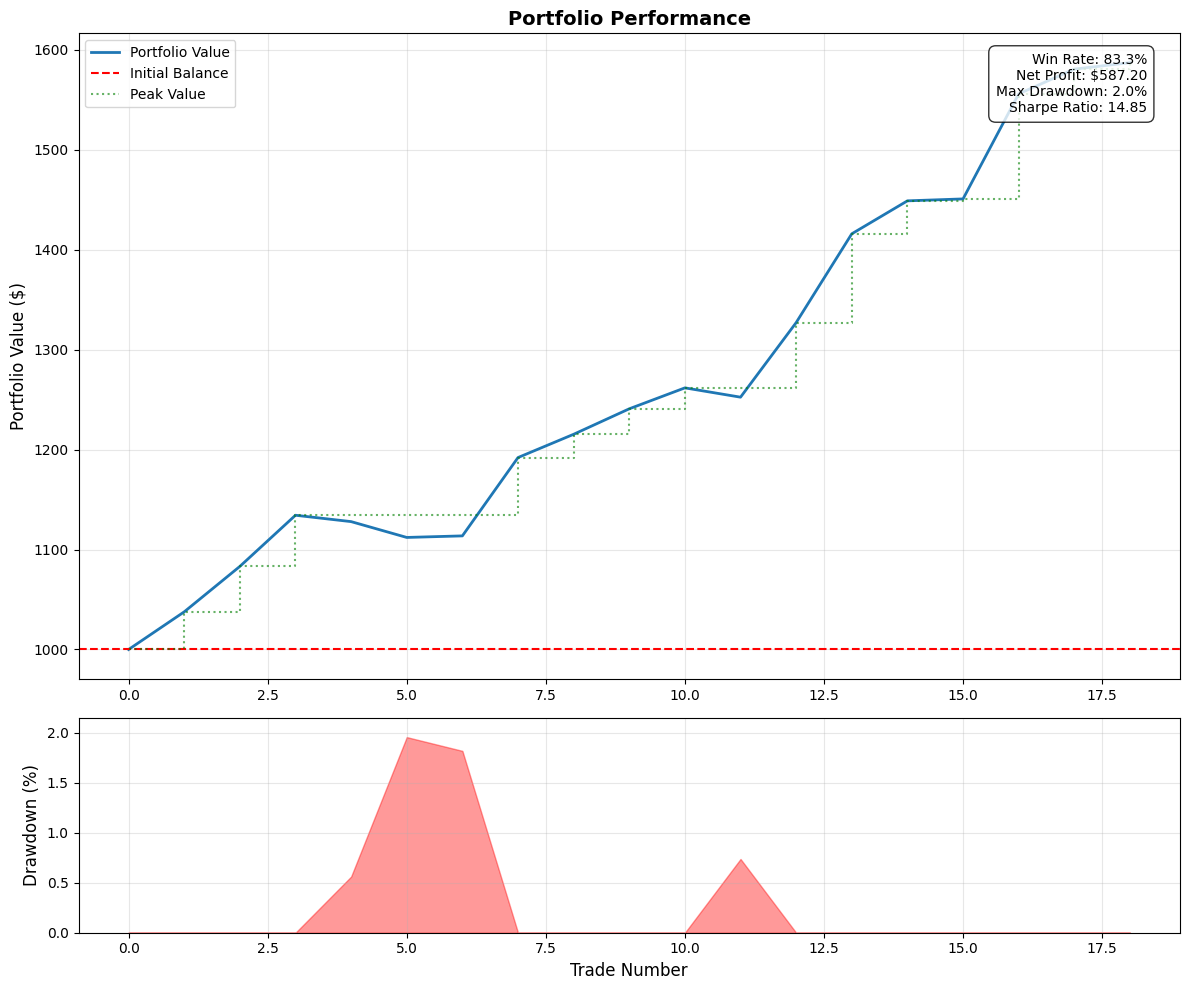

C:\Users\dizzy\AppData\Local\Temp\ipykernel_41328\3532244248.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_size = trade_data.groupby('size_category')['win'].mean() * 100


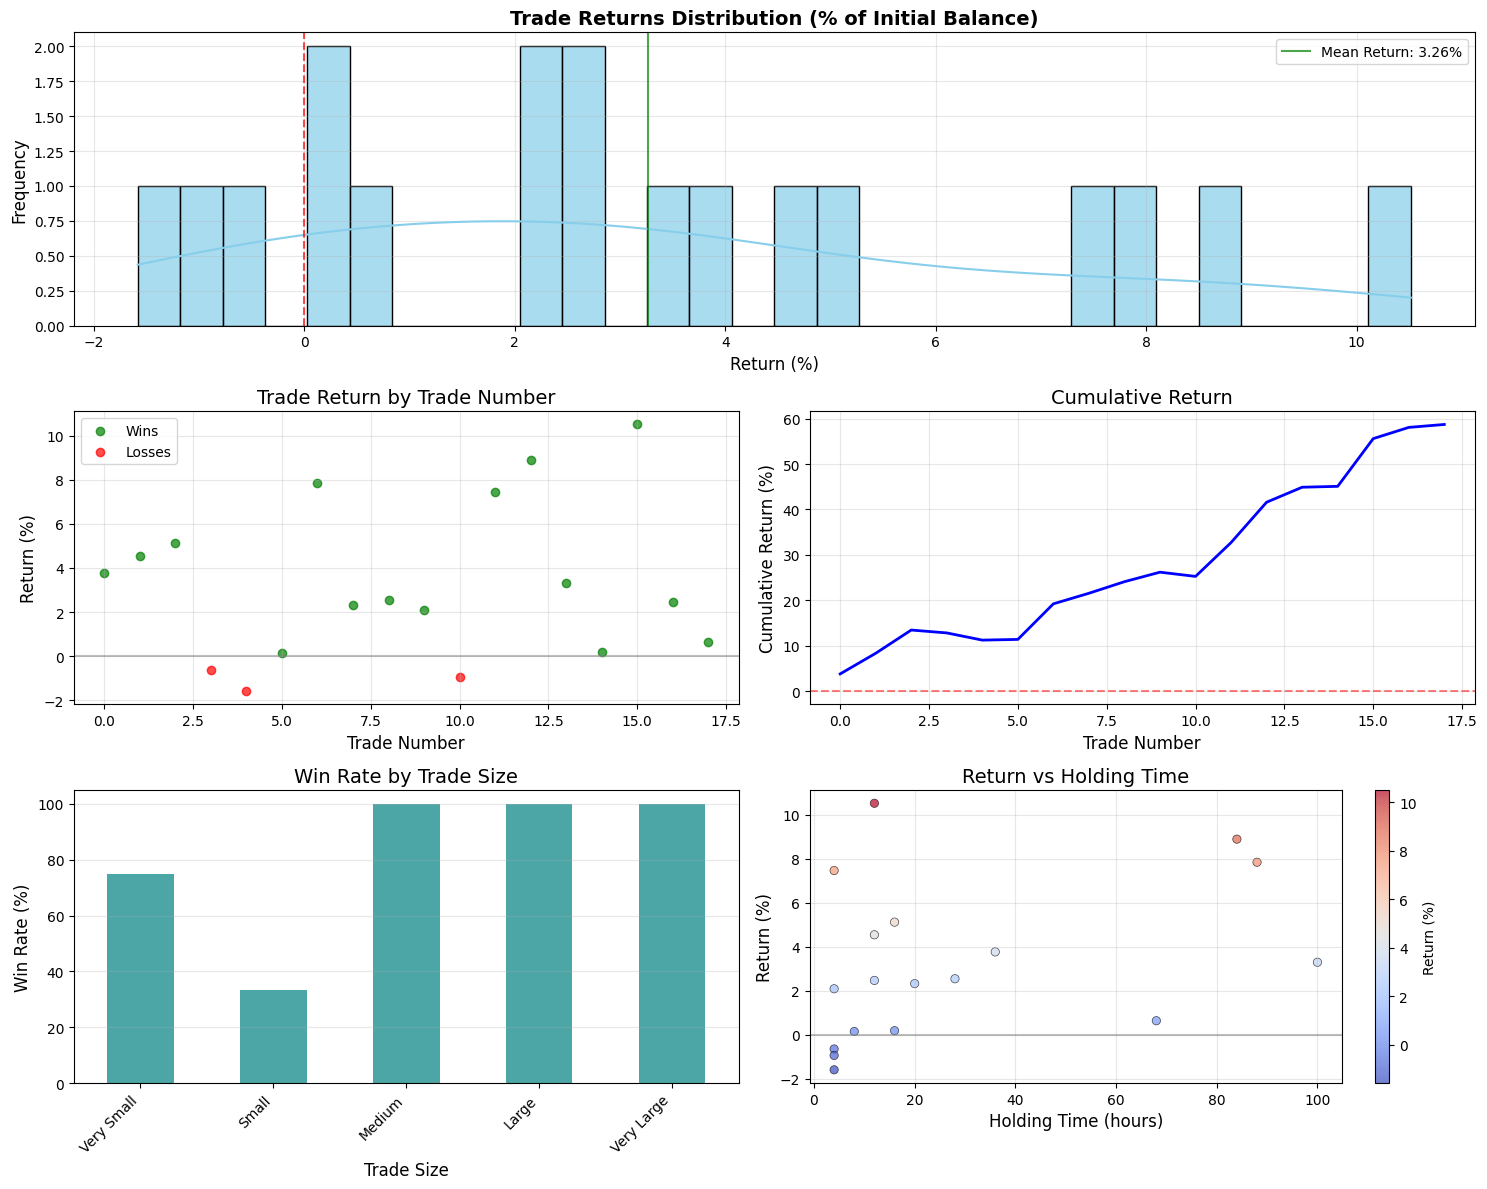

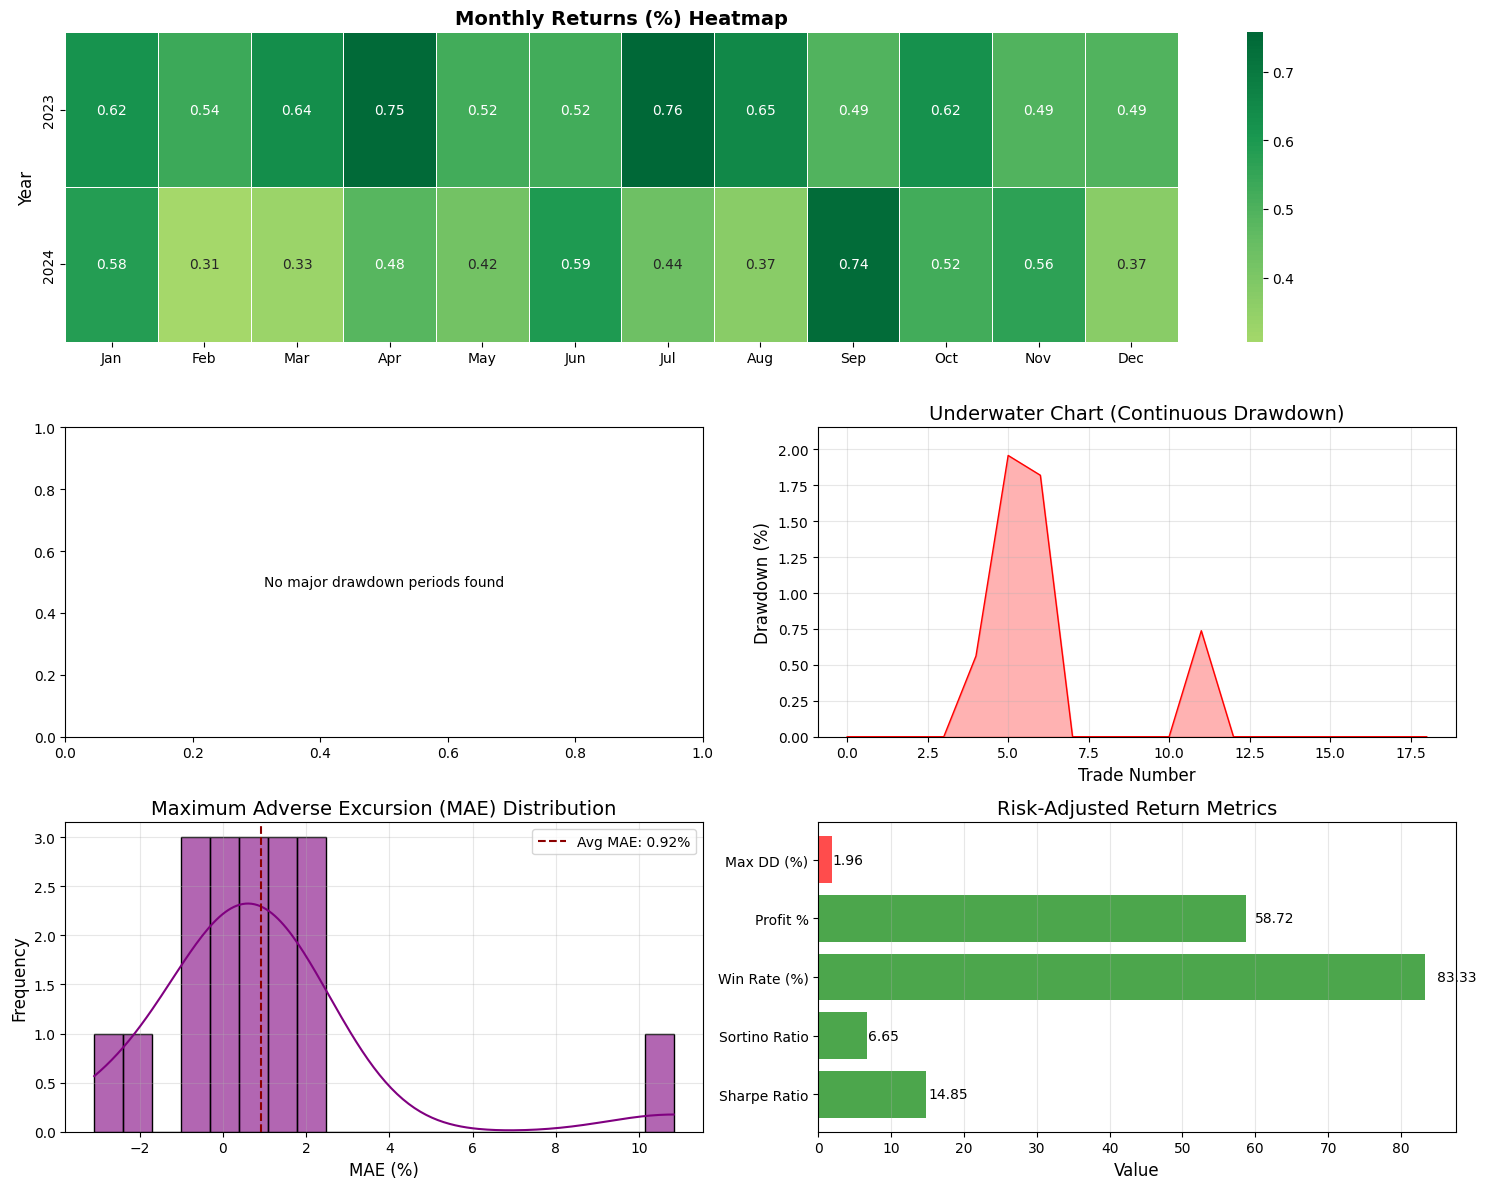

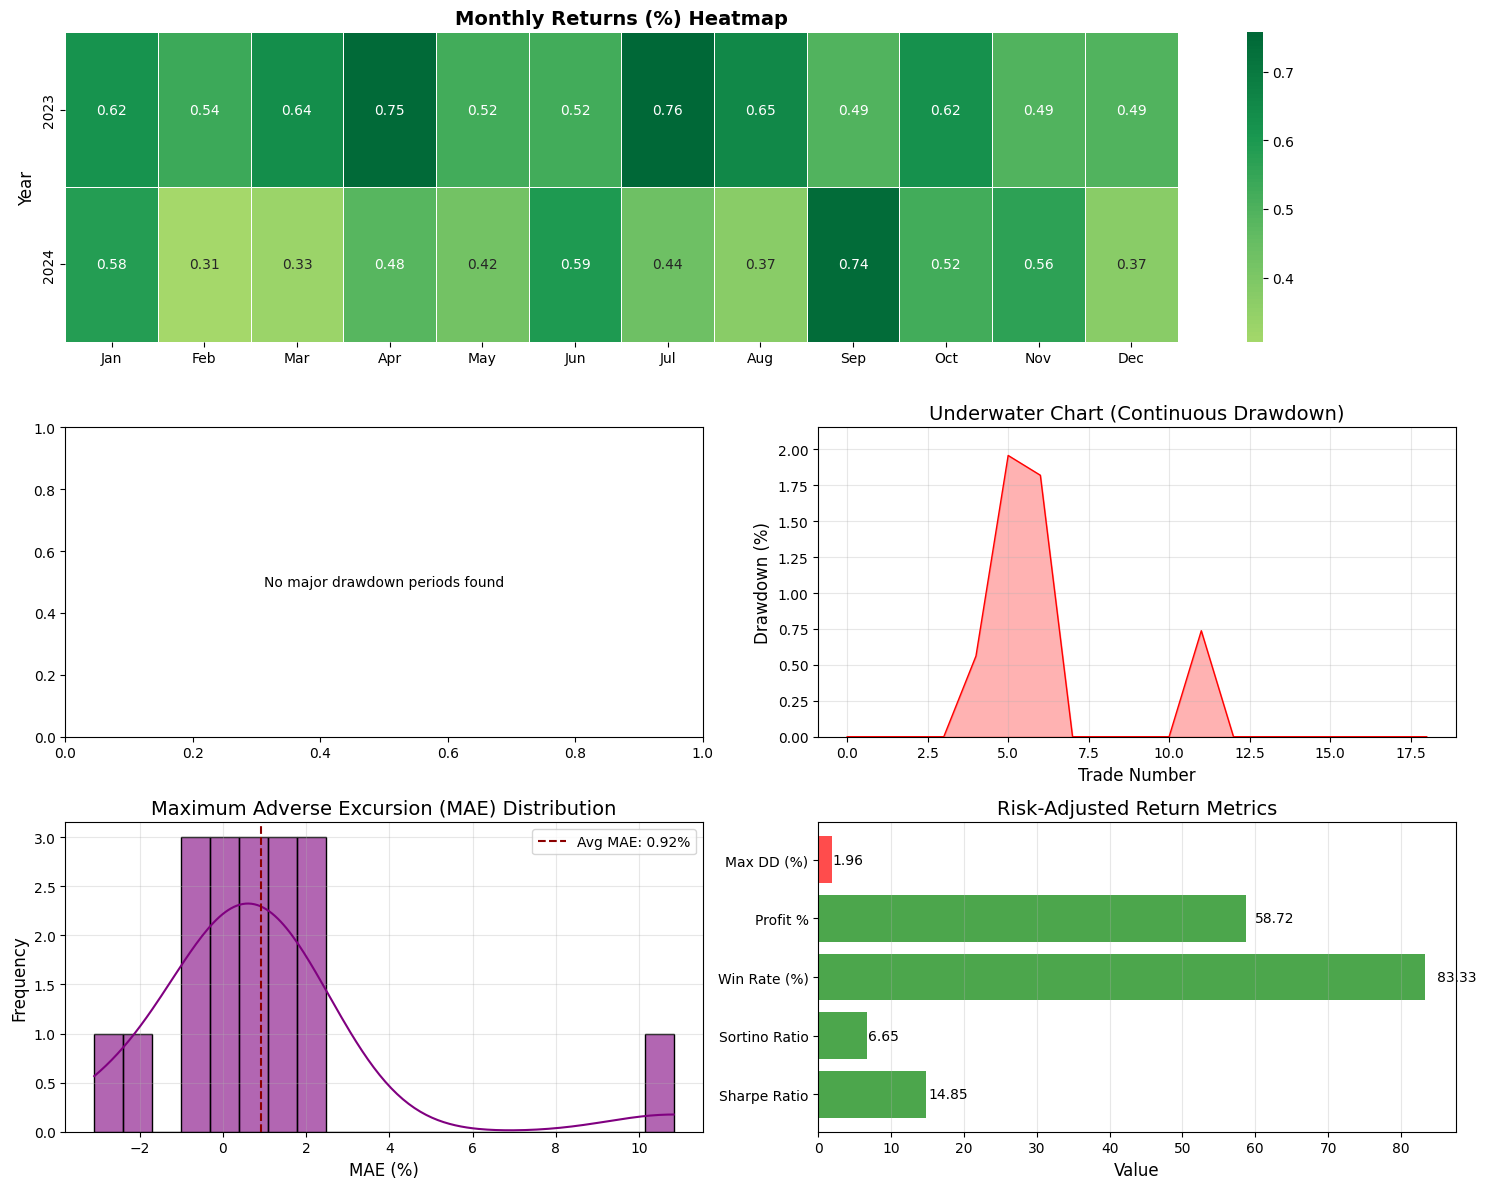

In [36]:
plot_portfolio_performance(backtester)
plot_trade_distribution(backtester)
plot_advanced_metrics(backtester)

In [4]:
print(backtester.portfolio_book[18])
print(backtester.portfolio_book[19])
print(backtester.portfolio_book[20])
print(backtester.portfolio_book[21])
# print(backtester.portfolio_book[22])

395.205675257248
419.6217197138728
415.62259046451965
381.5602092544713


In [5]:
for i in backtester.portfolio_book:
    print(i)

1000
1113.469230507745
166.08385661686543
163.32984662679092
171.59688643431159
656.61157212913
652.7048089563062
461.88429222848913
558.8393056239042
750.5430302406262
880.3628687909993
880.5264252294883
722.3609016567331
642.0943066541992
644.8145246188868
525.7642307526859
439.08998912844555
627.9733280626165
395.205675257248
419.6217197138728
415.62259046451965
381.5602092544713


In [6]:
# change in drawdown calculation..................if drawdown >100% ==> drawdown=100%==> portfolio wiped out